In [675]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import validation_curve
import time
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [676]:
pre_df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [ ]:
pre_df.head()

In [678]:
# preprocess data
# sort by imo number
pre_df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
pre_df['next_place'] = pre_df.groupby('IMO')['place.unlocode'].shift(-1)
pre_df['is_last_imo'] = pre_df['IMO'] != pre_df['IMO'].shift(-1)
pre_df = pre_df[~pre_df["is_last_imo"]]
pre_df = pre_df[pre_df["Event_Type"] != "ARRIVAL"]

In [ ]:
pre_df = pre_df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate"])
pre_df

In [680]:
pre_df[['place.unlocode', 'next_place']].head(1000)

,place.unlocode,next_place
314761,USLAX,CNJGY
314763,CNJGY,CNTXG
314765,CNTXG,CNQAW
314767,CNQAW,CNMSN
314769,CNMSN,CNNSA
...,...,...
154945,USPEF,USTXT
154947,USTXT,USPEF
154949,USPEF,USHOU
154951,USHOU,USPEF


In [681]:
print(pre_df.isna().sum())
pre_df = pre_df.dropna(subset=['place.unlocode', 'next_place'])

place.placeName      0
place.unlocode       0
place.placeType      0
place.countryName    0
vessel.vesselType    0
next_place           0
dtype: int64


In [682]:
# Ensure 'unlocode' is used to create unique indices
port_to_index = {port: idx for idx, port in enumerate(pre_df['place.unlocode'].unique())}
pre_df['cur_port_index'] = pre_df['place.unlocode'].map(port_to_index)
pre_df['next_port_index'] = pre_df['next_place'].map(port_to_index)

In [683]:
all_ports = set(pre_df['cur_port_index'].unique())
next_ports = set(pre_df['next_port_index'].unique())
missing_next_ports = all_ports - next_ports
print(missing_next_ports)
# Filter out entries where 'cur_port_index' is in the set of missing next ports
pre_df = pre_df[~pre_df['cur_port_index'].isin(missing_next_ports)]

# Check the new lengths after filtering
print(len(pre_df['cur_port_index'].unique()))
print(len(pre_df['next_port_index'].unique()))

{np.int64(1347), np.int64(1763), np.int64(1768), np.int64(1738), np.int64(1758), np.int64(1646), np.int64(1691), np.int64(1630)}
1764
1765


In [684]:
# reupdate port_to_index
port_to_index = {port: idx for idx, port in enumerate(pre_df['place.unlocode'].unique())}
pre_df['cur_port_index'] = pre_df['place.unlocode'].map(port_to_index)
pre_df['next_port_index'] = pre_df['next_place'].map(port_to_index)

In [685]:
pre_df = pre_df.dropna(subset=['next_port_index'])
pre_df.isna().sum()

place.placeName      0
place.unlocode       0
place.placeType      0
place.countryName    0
vessel.vesselType    0
next_place           0
cur_port_index       0
next_port_index      0
dtype: int64

In [686]:
# Check for any NaN which indicates missing mappings
assert pre_df['cur_port_index'].isna().sum() == 0, "Missing index mappings for current ports"
assert pre_df['next_port_index'].isna().sum() == 0, "Missing index mappings for next ports"

In [687]:
pre_df['next_port_index'] = pre_df['next_port_index'].astype(int)

In [ ]:
class_counts = pre_df['next_port_index'].value_counts()
min_class_count = class_counts.min()
df_balanced = pre_df.groupby('next_port_index').sample(n=min_class_count, random_state=1)
display(df_balanced.head(100))

In [689]:
import torch
from torch_geometric.data import Data

# Assuming node features are one-hot encoded for simplicity
num_nodes = len(port_to_index)
node_features = torch.eye(num_nodes)
print(num_nodes)
print(node_features.shape)

# Ensure the edge_index is correctly formatted
edge_index = torch.tensor([df_balanced['cur_port_index'].values, df_balanced['next_port_index'].values], dtype=torch.long)
print("Initial edge_index shape:", edge_index.shape)  # This should print [2, num_edges]

# Only transpose if necessary
if edge_index.shape[0] != 2:
    edge_index = edge_index.t().contiguous()
print("Corrected edge_index shape:", edge_index.shape)  # Ensure this is [2, num_edges]

labels = torch.tensor(df_balanced['next_port_index'].values, dtype=torch.long)

# Create the graph data object again
data = Data(x=node_features, edge_index=edge_index, y=labels)

# Print to verify the correct structure
print("Edge index shape:", data.edge_index.shape)  # Should print something like [2, 1764] if there are 1764 edges
print("Number of nodes:", data.num_nodes)  # Should match the highest node index plus one
print("Number of edges:", data.edge_index.size(1))  # Should correctly report the number of edges

max_edge_index = data.edge_index.max().item()
if max_edge_index >= data.num_nodes:
    raise ValueError(f"Edge index {max_edge_index} out of bounds for {data.num_nodes} nodes.")


1764
torch.Size([1764, 1764])
Initial edge_index shape: torch.Size([2, 1764])
Corrected edge_index shape: torch.Size([2, 1764])
Edge index shape: torch.Size([2, 1764])
Number of nodes: 1764
Number of edges: 1764


In [690]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

model = GCN(num_features=num_nodes, num_classes=num_nodes)

In [691]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate():
    model.eval()
    out = model(data)
    _, pred = out.max(dim=1)
    correct = pred.eq(data.y).sum().item()
    return correct / data.num_nodes

Epoch 1: Loss 7.4753, Accuracy 0.0057
Epoch 2: Loss 7.4736, Accuracy 0.0266
Epoch 3: Loss 7.4708, Accuracy 0.0680
Epoch 4: Loss 7.4671, Accuracy 0.1088
Epoch 5: Loss 7.4623, Accuracy 0.1315
Epoch 6: Loss 7.4558, Accuracy 0.1723
Epoch 7: Loss 7.4493, Accuracy 0.2375
Epoch 8: Loss 7.4414, Accuracy 0.2738
Epoch 9: Loss 7.4310, Accuracy 0.3073
Epoch 10: Loss 7.4208, Accuracy 0.3350
Epoch 11: Loss 7.4080, Accuracy 0.3503
Epoch 12: Loss 7.3990, Accuracy 0.3753
Epoch 13: Loss 7.3829, Accuracy 0.3855
Epoch 14: Loss 7.3655, Accuracy 0.4002
Epoch 15: Loss 7.3481, Accuracy 0.4150
Epoch 16: Loss 7.3241, Accuracy 0.4201
Epoch 17: Loss 7.3041, Accuracy 0.4252
Epoch 18: Loss 7.2784, Accuracy 0.4229
Epoch 19: Loss 7.2631, Accuracy 0.4246
Epoch 20: Loss 7.2288, Accuracy 0.4212
Epoch 21: Loss 7.1974, Accuracy 0.4263
Epoch 22: Loss 7.1601, Accuracy 0.4274
Epoch 23: Loss 7.1276, Accuracy 0.4246
Epoch 24: Loss 7.0961, Accuracy 0.4246
Epoch 25: Loss 7.0616, Accuracy 0.4229
Epoch 26: Loss 7.0193, Accuracy 0.

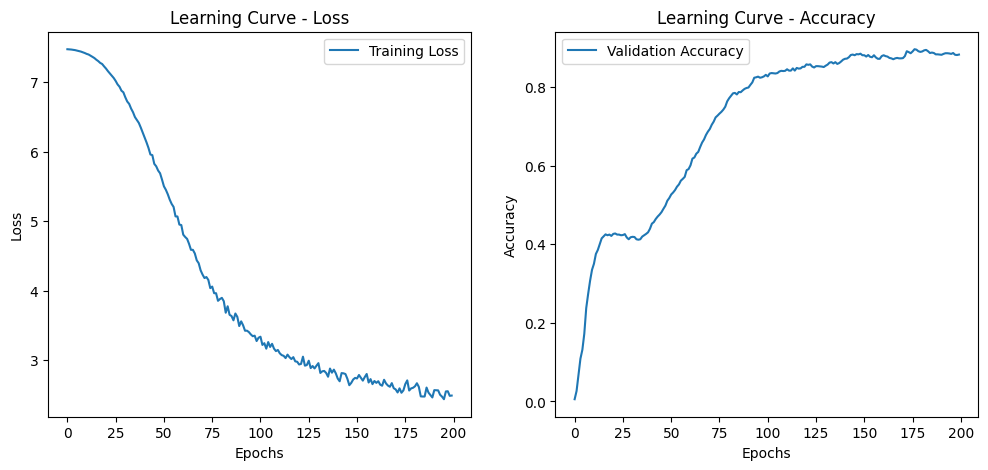

In [692]:
losses, accuracies = [], []
for epoch in range(200):
    loss = train()
    acc = evaluate()
    losses.append(loss)
    accuracies.append(acc)
    print(f'Epoch {epoch+1}: Loss {loss:.4f}, Accuracy {acc:.4f}')

# Plotting Learning and Validation Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# TODO: Add a testing split, cross validation and then learning curve